In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import networkx as nx
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator


In [2]:
# Import aircraft info
aircraft_info = pd.read_excel('Aircraft_fleet_info.xlsx')

# Transpose the dataframe 
aircraft_info = aircraft_info.T

# Promote the first row to column headers and drop the first row
aircraft_info.reset_index(inplace=True)
aircraft_info.columns = aircraft_info.iloc[0]
aircraft_info = aircraft_info.drop(aircraft_info.index[0])

# Split the Aircraft Type column into two columns at : and drop the original column and rename the new columns
aircraft_info[['Aircraft Type', 'Aircraft Type Name']] = aircraft_info['Aircraft Type'].str.split(':', expand=True)
aircraft_info.set_index('Aircraft Type', inplace=True)

# Make it a dictionary for each aircraft type
aircraft_info = aircraft_info.to_dict('index')

# Add kerosen flag to the dictionary
aircraft_info['Type 1']['Electric'] = 0
aircraft_info['Type 2']['Electric'] = 1
aircraft_info['Type 3']['Electric'] = 1

# Make a list of aircraft types
aircraft_types = list(aircraft_info.keys())


In [3]:
# Import distances 
distances = pd.read_csv('Group_4Regional_Distances.csv')

# Rename the unammed column to 'Origin'
distances.rename(columns={'Unnamed: 0':'Origin'}, inplace=True)
distances.set_index('Origin', inplace=True)

# Make it a dictionary
distances = distances.to_dict()

In [4]:
# Import airport info 
airport_info = pd.read_csv('Group_4Regional_Airport_info.csv')

hub = airport_info['ICAO Code'].iloc[0]
important_airport = airport_info['ICAO Code'].iloc[1]

# Make it a dictionary using the ICAO code as the key and the rest of the info in a sub-dictionary
airport_info = airport_info.set_index('ICAO Code').T.to_dict('dict')

# Create a list of the airport ICAO codes and sort it by distance from the hub
airport_list = list(airport_info.keys())
airport_list.sort(key = lambda x: distances[x][hub])

aiport_loc = {}
for e, i in enumerate(reversed(airport_list)):
    aiport_loc[i] = e


In [5]:
# Import demand data
daily_demand = pd.read_csv('Group_4Regional_Demand.csv')
daily_demand.rename(columns={'Unnamed: 0':'Origin'}, inplace=True)
daily_demand.set_index('Origin', inplace=True)
daily_demand = daily_demand.to_dict('index')

In [6]:
# Import the houly coefficients
hourly_coefficients = pd.read_csv('Group_4Hourly_coefficients.csv')
hourly_coefficients.rename(columns={'Unnamed: 0':'id', 'Unnamed: 1':'Origin Name', 'Unnamed: 2':'Origin ICAO'}, inplace=True)
hourly_coefficients.drop(columns=['id','Unnamed: 0.1','Origin Name'], inplace=True)
hourly_coefficients.set_index('Origin ICAO', inplace=True)

# Compute the hourly demand for each OD pair
hour_demand = {}
for origin in airport_list:
    for destination in airport_list:
        od_demand = daily_demand[origin][destination]
        hour_demand[origin,destination] = hourly_coefficients  * od_demand 

hourly_coefficients = hourly_coefficients.to_dict('index')


In [7]:
# Revenue

''' Create Yield matrix dict from formula in RPK using distance matrix
    Formula: Yield = 5.9 ∙ dij^(−0.76) + 0.043 '''

yield_matrix = {}
for i in airport_list:
    yield_matrix[i] = {}
    for j in airport_list:
        if i == j:
            yield_matrix[i][j] = 0
        else:
            yield_matrix[i][j] = 5.9 * (distances[i][j] ** (-0.76)) + 0.043


In [8]:
# Costs 
# Operational costs

''' Fixed costs = CXk  '''
fixed = {}
for k in aircraft_types:
    fixed[k] = aircraft_info[k]['Fixed Operating Cost (Per Fligth Leg)  [€]']

''' Time based costs i -> j
    Formula: CTkij = cTk ∙ dij / Vk '''
time_based = {}
for k in aircraft_types:
    time_based[k] = {}
    for i in airport_list:
        time_based[k][i] = {}
        for j in airport_list:
            time_based[k][i][j] = aircraft_info[k]['Cost per Hour'] * distances[i][j] / aircraft_info[k]['Speed [km/h]']

''' Fuel costs i -> j
    Formula: CFkij = cFk ∙ dij ∙ f / 1.5'''
fuel_gal_cost = 1.42 
fuel = {}
for k in aircraft_types:
    fuel[k] = {}
    for i in airport_list:
        fuel[k][i] = {}
        for j in airport_list:
            if aircraft_info[k]['Electric'] == 1:
                fuel[k][i][j] = 0
            else:
                fuel[k][i][j] = aircraft_info[k]['Fuel Cost Parameter'] * distances[i][j] * fuel_gal_cost / 1.5

''' Energy costs i -> j
    Formula: CEkij = e ∙ Gk ∙ dij / Rk '''
energy = {}
for k in aircraft_types:
    energy[k] = {}
    for i in airport_list:
        energy[k][i] = {}
        for j in airport_list:
            if aircraft_info[k]['Electric'] == 0:
                energy[k][i][j] = 0
            else:
                energy[k][i][j] = 0.07 * aircraft_info[k]['Batteries energy (kWh)'] * distances[i][j] / aircraft_info[k]['Maximum Range [km]']

''' Total operational costs i -> j
    Formula: CXk + CTkij + CFkij + CEkij '''
hub_factor = 0.7
op_costs = {}
for k in aircraft_types:
    op_costs[k] = {}
    for i in airport_list:
        op_costs[k][i] = {}
        for j in airport_list:
            if i == hub or j == hub:
                op_costs[k][i][j] = (fixed[k] + time_based[k][i][j] + fuel[k][i][j]) * hub_factor + energy[k][i][j]
            else:
                op_costs[k][i][j] = fixed[k] + time_based[k][i][j] + fuel[k][i][j] + energy[k][i][j]
            if i == j:
                op_costs[k][i][j] = 0
            if distances[i][j] > aircraft_info[k]['Maximum Range [km]'] or airport_info[i]['Runway (m)'] < aircraft_info[k]['Runway Required [m]'] or airport_info[j]['Runway (m)'] < aircraft_info[k]['Runway Required [m]']:
                op_costs[k][i][j] = 10000000
                

In [9]:
''' Time i -> j
    Formula: dij / Vk + TATk + 30 (landing and takeoff) + additional charging time (if electric) '''
times = {}
for k in aircraft_types:
    times[k] = {}
    for i in airport_list:
        times[k][i] = {}
        for j in airport_list:
            times[k][i][j] = {}
            if i == j:
                times[k][i][j] = 0.1
            else:
                times[k][i][j] = math.ceil((distances[i][j] / aircraft_info[k]['Speed [km/h]'] * 60
                                + aircraft_info[k]['Average TAT [min]']
                                + 30
                                + (aircraft_info[k]['Additional charging time'] if aircraft_info[k]['Electric'] == 1 else 0)) * 10 / 60) / 10

In [10]:
# Create a list of all possible time steps
time_steps = list((np.arange(0, 24, 0.1)))

for i,t in enumerate(time_steps):
    time_steps[i] = round(t, 1)

hours = list((np.arange(0, 24, 1)))

In [11]:
# Create a demand dictionary for each time step only from and to the hub
hourly_demand = {}
for i in airport_list:
    for j in airport_list:
        if (i == hub or j == hub) and i != j:
            hourly_demand[i,j] = {}
            for t in hours:
                hourly_demand[i,j][t] = daily_demand[i][j] * (hourly_coefficients[i][str(math.floor(t))])

In [12]:
def incoming_flights(k):
    '''
    Create a dictionary of all possible incoming flights from the hub
    '''
    incoming = {}
    for i in airport_list:
        if i == hub:
            continue
        incoming[i, hub] = {}
        for t in time_steps:
            arrival = round(t + times[k][i][hub],ndigits=1)
            if arrival <= 24:
                if t >= times[k][i][hub]:
                    incoming[i, hub][t, arrival] = {}
                    incoming[i, hub][t, arrival]['pax'] = min(aircraft_info[k]['Seats'], 
                                        hourly_demand[i, hub][math.floor(t)]
                                        + (hourly_demand[i, hub][math.floor(t-1)] if t >= 1 else 0)
                                        + (hourly_demand[i, hub][math.floor(t+1)] if t <= 22.9 else 0)
                                        + (hourly_demand[i, hub][math.floor(t-2)] if t >= 2 else 0))
                    incoming[i, hub][t, arrival]['cost'] = op_costs[k][i][hub]
                    incoming[i, hub][t, arrival]['RPK'] = yield_matrix[i][hub]
                    incoming[i, hub][t, arrival]['profit'] = distances[i][hub] * incoming[i, hub][t, arrival]['pax'] * yield_matrix[i][hub] - op_costs[k][i][hub]
    return incoming

In [13]:
def outgoing_flights(k):
    '''
    Create a dictionary of all possible outgoing flights from the hub
    '''
    outgoing = {}
    for i in airport_list:
        if i == hub:
            continue
        outgoing[hub, i] = {}
        for t in time_steps:
            arrival = round(t + times[k][hub][i], ndigits=1)
            if arrival <= 24:
                if arrival <= 24 - times[k][hub][i]:
                    outgoing[hub, i][t, arrival] = {}
                    outgoing[hub, i][t, arrival]['pax'] = min(aircraft_info[k]['Seats'], 
                                        hourly_demand[hub, i][math.floor(t)]
                                        + (hourly_demand[hub, i][math.floor(t-1)] if t >= 1 else 0)
                                        + (hourly_demand[hub, i][math.floor(t+1)] if t <= 22.9 else 0)
                                        + (hourly_demand[hub, i][math.floor(t-2)] if t >= 2 else 0))
                    outgoing[hub, i][t, arrival]['cost'] = op_costs[k][hub][i]
                    outgoing[hub, i][t, arrival]['RPK'] = yield_matrix[hub][i]
                    outgoing[hub, i][t, arrival]['profit'] = distances[hub][i] * outgoing[hub, i][t, arrival]['pax'] * yield_matrix[hub][i] - op_costs[k][hub][i]
    return outgoing
    

In [14]:
def nodes_and_self_flights(k):
    '''
    Creates a dictionary of nodes and a dictionary of self arcs for each aircraft type
    '''
    nodes_ntwrk = {}
    self_arcs = {}
    for i in airport_list:
        nodes_ntwrk[i] = []
        self_arcs[i,i] = {}
        for t in time_steps:
            arrival = round(t + times[k][i][i], ndigits=1)
            if arrival <= 24 - times[k][hub][i] and t >= times[k][i][hub] or times[k][hub][i] == 0.1:
                self_arcs[i,i][t, arrival] = {0}
                nodes_ntwrk[i].append(t)

    for i in airport_list:
        nodes_ntwrk[i].append(round(max(nodes_ntwrk[i]) + 0.1, ndigits=1))

    return nodes_ntwrk, self_arcs

In [15]:
def define_graph(nodes_ntwrk, incoming, outgoing, self_arcs):
    ''' 
    Creates a directed graph with nodes and edges
    '''
    G = nx.DiGraph()

    # Add nodes
    for i in airport_list:
        for n in nodes_ntwrk[i]:
            G.add_node((n, i), airport=i, pos=np.array([n, aiport_loc[i]]), stage = int(n * 10))

    # Add edges
    for o,d in incoming.keys():
        for t1,t2 in incoming[o,d].keys():
            G.add_edge((t1, o), (t2, d), weight = incoming[o,d][t1,t2]['profit'], departure = t1, arrival = t2, pax = incoming[o,d][t1,t2]['pax'])

    for o,d in outgoing.keys():
        for t1,t2 in outgoing[o,d].keys():
            G.add_edge((t1, o), (t2, d), weight = outgoing[o,d][t1,t2]['profit'], departure = t1, arrival = t2, pax = outgoing[o,d][t1,t2]['pax'])

    for o,d in self_arcs.keys():
        for t1,t2 in self_arcs[o,d].keys():
            G.add_edge((t1, o), (t2, d), weight = 0, departure = t1, arrival = t2, pax = 0)
    
    stages = {}
    n = 241
    for stage in range(0, n):
        stages[stage] = [node for node in G.nodes() if G.nodes[node]['stage'] == stage]

    return G, stages

In [16]:
def total_profit(G, stages, n):
    f_n_ast = {}
    f_n_ast[240] = {(24.0, hub): 0}
    x_n_ast = {(24.0, hub): []}
    for stage in range(n - 2, -1, -1):
        f_n_s = {}
        for node in stages[stage]:
            for dest in G.successors(node):
                if node not in x_n_ast:
                    x_n_ast[node] = []
                if node in f_n_s:
                    if f_n_s[node] < f_n_ast[G.nodes[dest]['stage']][dest] + G[node][dest]['weight']:
                        x_n_ast[node] = [dest]
                    elif f_n_s[node] == f_n_ast[G.nodes[dest]['stage']][dest] + G[node][dest]['weight']:
                        x_n_ast[node].append(dest)
                    f_n_s[node] = max(f_n_s[node], f_n_ast[G.nodes[dest]['stage']][dest] + G[node][dest]['weight'])
                else:
                    f_n_s[node] = f_n_ast[G.nodes[dest]['stage']][dest] + G[node][dest]['weight']
                    x_n_ast[node].append(dest)
                f_n_ast[stage] = f_n_s
    return f_n_ast, x_n_ast

In [17]:
def find_all_paths(ast, start, end, path=[]):
    '''
    Find all paths between two nodes
    '''
    path = path + [start]
    if start == end:
        return [path]
    
    paths = []
    for node in ast[start]:
        if node not in path:
            newpaths = find_all_paths(ast, node, end, path)
            for newpath in newpaths:
                paths.append(newpath)
    return paths


In [18]:
def itinerary_calculation(results, k):
    # Create a directed graph with nodes and edges
    G_ast = nx.DiGraph()
    for node in results[k]['links'].keys():
        G_ast.add_node(node, airport=node[1], pos=np.array([node[0], aiport_loc[node[1]]]), stage = int(node[0] * 10))

    for orig in results[k]['links'].keys():
        for dest in results[k]['links'][orig]:
            G_ast.add_edge(orig, dest, weight = results[k]['graph'][orig][dest]['weight'], departure = orig[0], arrival = dest[0], pax = results[k]['graph'][orig][dest]['pax'])

    for stage in results[k]['n_profit']:
        for node in results[k]['n_profit'][stage]:
            G_ast.nodes[node]['tot_profit'] = results[k]['n_profit'][stage][node]

    # Using a greedy algorithm find the itinerary that maximizes the total profit
    orig = (0.0, hub)
    dest = (24.0, hub)
    itinerary = [orig]
    curr = orig
    while curr != dest:
        next = None
        max_profit = 0

        for node in G_ast.successors(curr):
            if G_ast.nodes[node]['tot_profit'] >= max_profit:
                next = node
                max_profit = G_ast.nodes[node]['tot_profit']
        
        if next != None:
            itinerary.append(next)
            curr = next
        else: 
            curr = dest
    
    return itinerary, G_ast

In [19]:
def itinerary_output(itinerary, G_ast, k):
    # Make a dataframe with the itinerary
    columns = ['Departure time', 'Route', 'Arrival time', 'Passengers','Profit', 'Origin', 'Destination']

    itinerary_df = pd.DataFrame(columns=columns)

    for i in range(1, len(itinerary) - 1):
        itinerary_df.loc[i] = [
            itinerary[i][0], 
            itinerary[i][1] + ' -> ' + itinerary[i+1][1], 
            itinerary[i+1][0], 
            G_ast[itinerary[i]][itinerary[i+1]]['pax'],
            G_ast[itinerary[i]][itinerary[i+1]]['weight'],
            itinerary[i][1],
            itinerary[i+1][1]]

        
    # Remove rows with no profit
    itinerary_df = itinerary_df[itinerary_df['Profit'] != 0]
    itinerary_df.reset_index(drop=True, inplace=True)
    # Make the times readable using datetime 
    itinerary_df['Flight time'] = itinerary_df['Arrival time'] - itinerary_df['Departure time']
    itinerary_df['Departure time']  = pd.to_datetime(itinerary_df['Departure time'], unit='h').dt.time
    itinerary_df['Arrival time']  = pd.to_datetime(itinerary_df['Arrival time'], unit='h').dt.time

    # Unique OD pair
    itinerary_df['OD Pair'] = itinerary_df.apply(lambda x: x['Origin'] + ' - ' + x['Destination'] if x['Origin'] < x['Destination'] else x['Destination'] + ' - ' + x['Origin'], axis=1)

    # Create a new sheet in an excel file with the itinerary and the name k + iteration number
    return itinerary_df

In [20]:
def update_demand(itinerary, hourly_demand, G_ast):
    '''
    Update the demand for each OD pair based on the itinerary
    '''
    for i in range(len(itinerary) - 1):
        origin = itinerary[i][1]
        destination = itinerary[i+1][1]
        if origin != destination:
            flight_demand = G_ast[itinerary[i]][itinerary[i+1]]['pax']
            t = math.floor(itinerary[i][0])
            previous_demand = hourly_demand[origin, destination][t]
            hourly_demand[origin, destination][t] = hourly_demand[origin, destination][t] - min(flight_demand, hourly_demand[origin, destination][t])
            flight_demand = max(flight_demand - previous_demand, 0)

            if flight_demand > 0 and t >= 1:
                t_1 = round(t - 1, ndigits=1)
                previous_demand = hourly_demand[origin, destination][t_1]
                hourly_demand[origin, destination][t_1] = hourly_demand[origin, destination][t_1] - min(flight_demand, hourly_demand[origin, destination][t_1])
                flight_demand = max(flight_demand - previous_demand,0)

            if flight_demand > 0 and t <= 22.9:
                t_1 = round(t + 1, ndigits=1)
                previous_demand = hourly_demand[origin, destination][t_1]
                hourly_demand[origin, destination][t_1] = hourly_demand[origin, destination][t_1] - min(flight_demand, hourly_demand[origin, destination][t_1])
                flight_demand = max(flight_demand - previous_demand,0)
                
            if flight_demand > 0 and t >= 2:
                t_1 = round(t - 2, ndigits=1)
                previous_demand = hourly_demand[origin, destination][t_1]
                hourly_demand[origin, destination][t_1] = hourly_demand[origin, destination][t_1] - min(flight_demand, hourly_demand[origin, destination][t_1])
                flight_demand = max(flight_demand - previous_demand,0)
                        
    return hourly_demand


In [21]:
# Run for each aircraft type
def dp_iteration(aircraft_types, hourly_demand, hub, iter, aircraft_info):
    print('Iteration ' + str(iter))
    results = {}
    for k in aircraft_types:
        if aircraft_info[k]['Fleet'] > 0:
            results[k] = {}
            incoming = incoming_flights(k)
            outgoing = outgoing_flights(k)
            nodes_ntwrk, self_arcs = nodes_and_self_flights(k)
            G, stages = define_graph(nodes_ntwrk, incoming, outgoing, self_arcs)
            f_n_ast, x_n_ast = total_profit(G, stages, 241)
            profit_k = f_n_ast[0][(0, hub)] - aircraft_info[k]['Lease Cost [€]']
            results[k]['total profit'] = profit_k
            results[k]['n_profit'] = f_n_ast
            results[k]['links'] = x_n_ast
            results[k]['graph'] = G
            
            if profit_k > 0:
                itinerary, G_ast = itinerary_calculation(results, k)
                itinerary_df = itinerary_output(itinerary, G_ast, k)
                # print(G_ast.nodes(data=True))
                results[k]['block time'] = itinerary_df['Flight time'].sum()
                print('Total profit for '+ k + ': %0.0f' % profit_k)
                print('Total BT for '+ k + ': %0.0f' % (results[k]['block time']))
                results[k]['itinerary'] = itinerary
                results[k]['itinerary DF'] = itinerary_df
                results[k]['G_ast'] = G_ast

            else: 
                print('Total profit for '+ k + ': Non Profitable')
    
    # Keep only the best solution by profit
    best_profit = 0
    for k in aircraft_types:
        if aircraft_info[k]['Fleet'] > 0  and results[k]['total profit'] > best_profit:
                best_profit = results[k]['total profit']
                best_k = k
    
    if best_profit <= 0:
        print('No feasible solution')
        return
    
    final_results = results[best_k]
    final_results['aircraft type'] = best_k

    # Update the fleet info
    aircraft_info[best_k]['Fleet'] = aircraft_info[best_k]['Fleet'] - 1

    itinerary = final_results['itinerary']
    itinerary_df = final_results['itinerary DF']
    G_ast = final_results['G_ast']

    # Update the demand
    hourly_demand = update_demand(itinerary, hourly_demand, G_ast)

    return itinerary_df, itinerary, best_k, G_ast, final_results['n_profit'], best_profit

In [22]:
def self_nodes(itinerary):
    self_nodes = []
    # From the itinerary list remove the nodes with the same profit as the last 
    for i in range(1, len(itinerary) - 1):
        if itinerary[i][0] == round(itinerary[i-1][0] + 0.1, 1)  and itinerary[i][0] == round(itinerary[i+1][0] - 0.1, 1):
            self_nodes.append(itinerary[i])

    for node in self_nodes:
        itinerary.remove(node)
    return itinerary

In [23]:
def plot_itinerary(itinerary, G_ast, k, it, f_n_ast):
    # Plot the itinerary with matplotlib
    G_graph = nx.DiGraph()

    for node in itinerary:
        G_graph.add_node(node, airport=node[1], pos=np.array([node[0], aiport_loc[node[1]]]))

    for i in range(len(itinerary)-1):
        G_graph.add_edge(itinerary[i], itinerary[i+1], departure = itinerary[i][0], arrival = itinerary[i+1][0])
        if (itinerary[i],itinerary[i+1]) in list(G_ast.edges()):
            G_graph[itinerary[i]][itinerary[i+1]]['weight'] = int(round(G_ast[itinerary[i]][itinerary[i+1]]['weight'],0))
        else:
            G_graph[itinerary[i]][itinerary[i+1]]['weight'] = 0

    
    for stage in f_n_ast:
        for node in list(G_graph.nodes()):
            if node in f_n_ast[stage]:
                G_graph.nodes[node]['profit'] = int(round(f_n_ast[stage][node],0))

    fig, ax = plt.subplots(figsize=(16, 4))
    ax.set_ylim(-1, 12)
    pos = nx.get_node_attributes(G_graph, 'pos')
    node_labels = nx.get_node_attributes(G_graph,'profit')
    nx.draw_networkx(G_graph, pos, arrows=True, with_labels=False, node_size=50, node_color='skyblue', edge_color='black', linewidths=1, font_size=8, label='Itinerary', ax=ax)
    edge_labels = nx.get_edge_attributes(G_graph,'weight')
    nx.draw_networkx_edge_labels(G_graph, pos, edge_labels=edge_labels, font_size=8)

    # Add the total cost to the nodes as a label and offset it 0.15 up
    node_labels_pos = {}
    
    for node in node_labels:
        if node[1] == hub:
            node_labels_pos[node] = pos[node] + np.array([0,0.55])
        else:
            node_labels_pos[node] = pos[node] - np.array([0,0.55])
    
    nx.draw_networkx_labels(G_ast, node_labels_pos, labels=node_labels, font_size=10, font_color='red')

    # nx.draw_networkx_labels(G_ast, pos, labels=node_labels, font_size=10, font_color='red')

    # Show the axes and the ticks
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    
    # Add the axes labels for the airports and the time with ticks every hour
    ax.set_xticks(np.arange(0, 25, 1))
    ax.set_xticklabels(np.arange(0, 25, 1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.set_yticks(np.arange(0, len(airport_list)))
    ax.set_yticklabels(reversed(airport_list))
    
    plt.xlabel('Time')
    plt.ylabel('Airport')
    plt.title('Itinerary' + ' for ' + k + ' in iteration ' + str(it))
    plt.grid(axis = 'y', alpha = 0.3)

    # Show the plot
    #fig1 = plt.gcf()
    plt.show()
    #fig1.savefig('Figures/Itinerary' + ' for ' + k + ' in iteration ' + str(it) + '.pdf')

    return G_graph

Iteration 1
Total profit for Type 1: 9600
Total BT for Type 1: 19
Total profit for Type 2: 6249
Total BT for Type 2: 19
Total profit for Type 3: Non Profitable


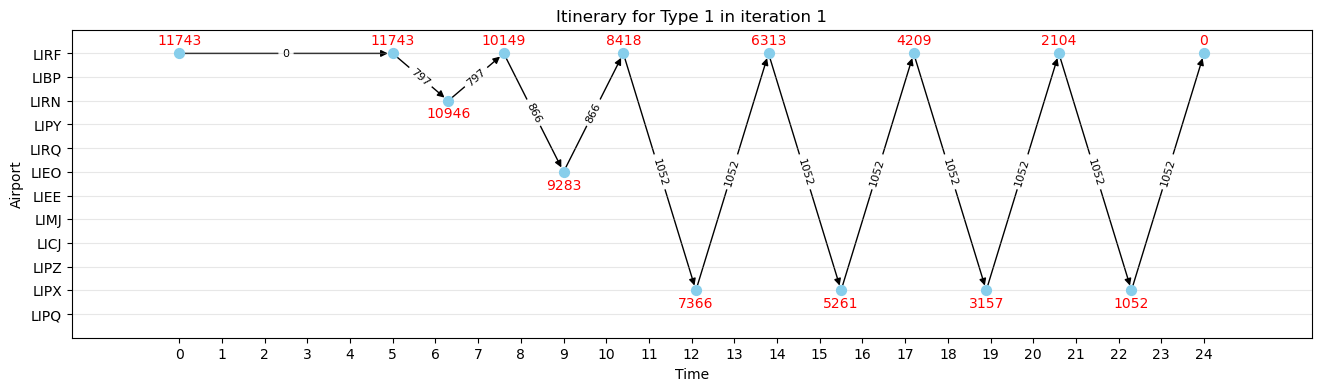

Iteration 2
Total profit for Type 1: 9600
Total BT for Type 1: 19
Total profit for Type 2: 6249
Total BT for Type 2: 19
Total profit for Type 3: Non Profitable


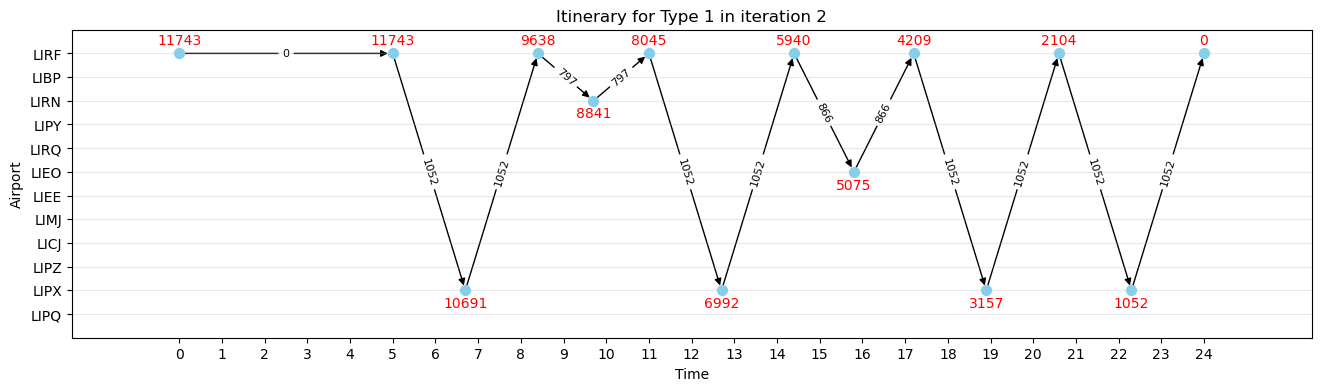

Iteration 3
Total profit for Type 1: 9591
Total BT for Type 1: 19
Total profit for Type 2: 6226
Total BT for Type 2: 19
Total profit for Type 3: Non Profitable


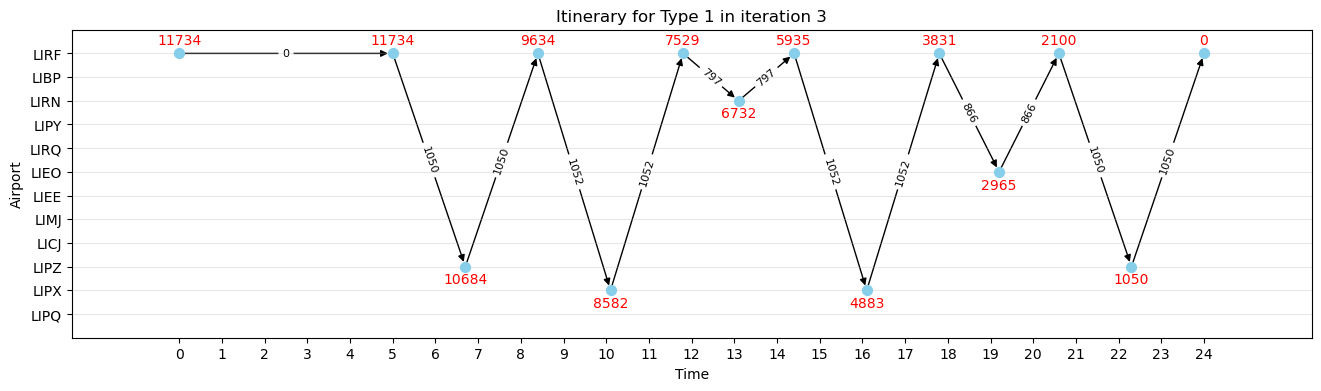

Iteration 4
Total profit for Type 1: 9553
Total BT for Type 1: 19
Total profit for Type 2: 6226
Total BT for Type 2: 19
Total profit for Type 3: Non Profitable


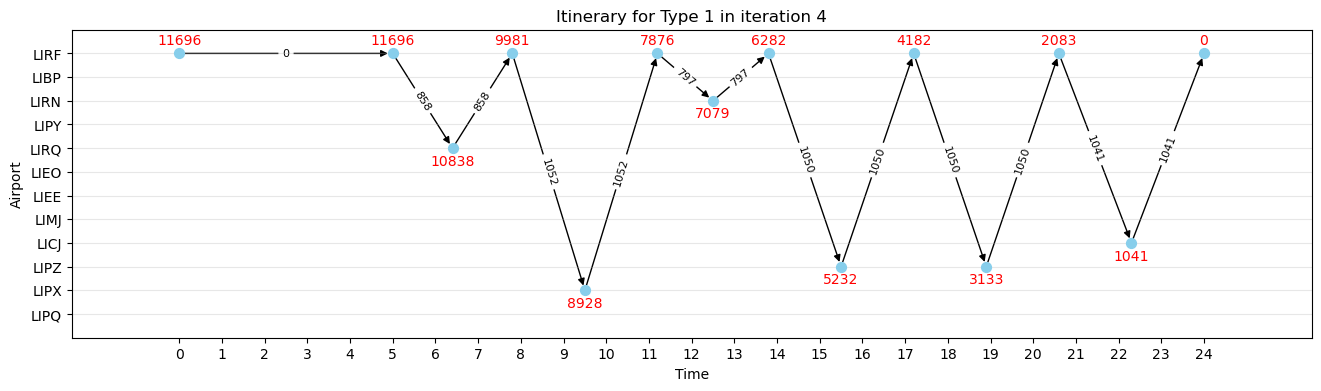

Iteration 5
Total profit for Type 1: 9206
Total BT for Type 1: 19
Total profit for Type 2: 5847
Total BT for Type 2: 20
Total profit for Type 3: Non Profitable


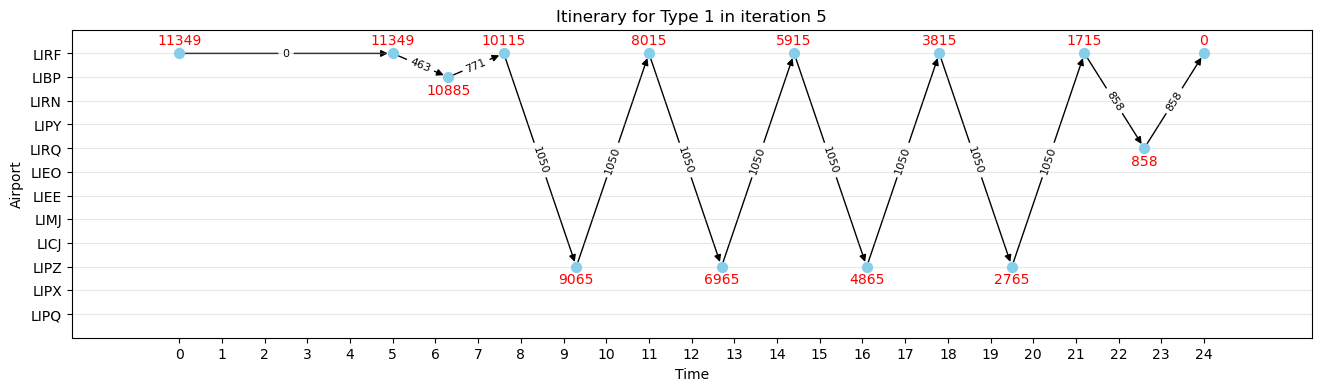

Iteration 6
Total profit for Type 2: 5847
Total BT for Type 2: 20
Total profit for Type 3: Non Profitable


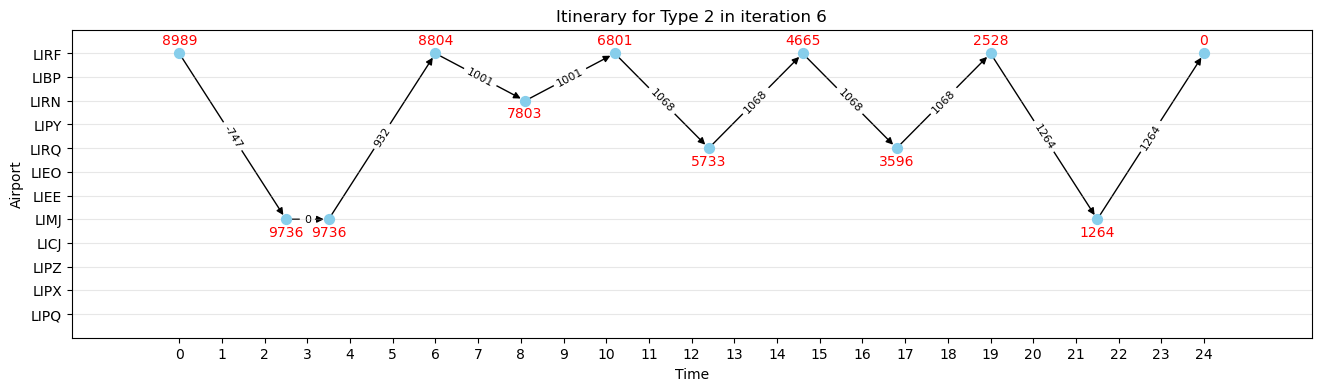

Iteration 7
Total profit for Type 2: 5766
Total BT for Type 2: 19
Total profit for Type 3: Non Profitable


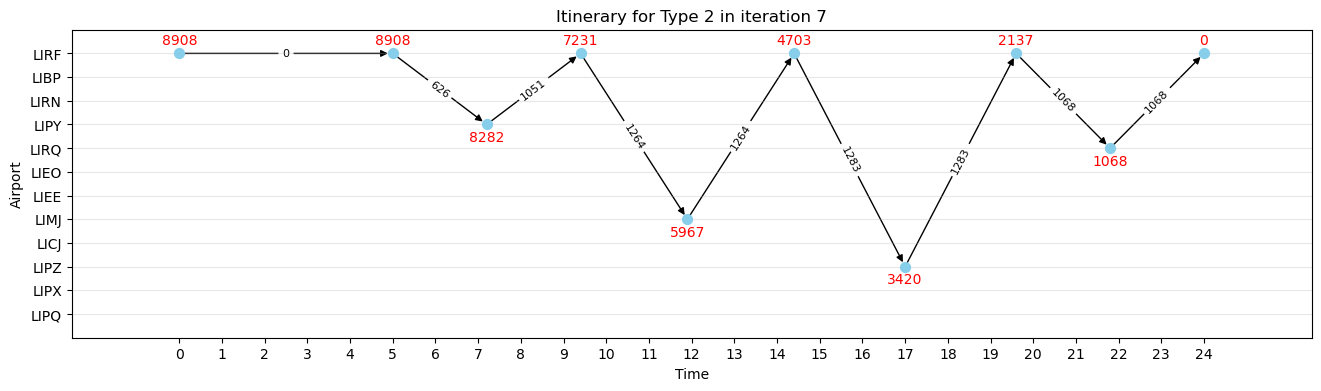

Iteration 8
Total profit for Type 2: 5672
Total BT for Type 2: 19
Total profit for Type 3: Non Profitable


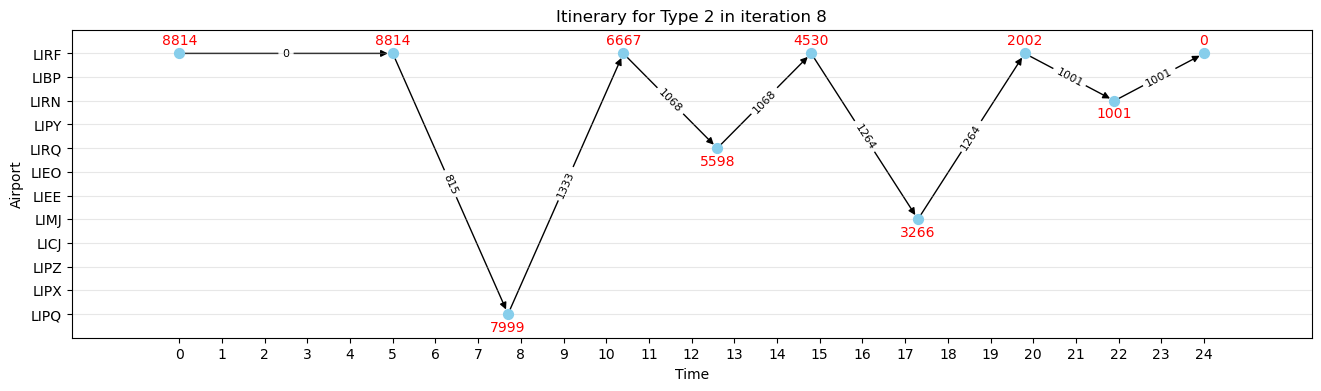

Iteration 9
Total profit for Type 3: Non Profitable
No feasible solution
Iteration 10
Total profit for Type 3: Non Profitable
No feasible solution
Iteration 11
Total profit for Type 3: Non Profitable
No feasible solution
Optimal solution: 64835


In [24]:
total_fleet = int(sum([aircraft_info[k]['Fleet'] for k in aircraft_types]))
writer = pd.ExcelWriter('itineraries.xlsx', engine='xlsxwriter')
general_output = []
general_graph = []
optimal_solution = 0


for i in range(1, total_fleet + 1):
    try: 
        output_df, itinerary, best_k, G_ast, f_ast, profit_i= dp_iteration(aircraft_types, hourly_demand, hub, i, aircraft_info)
    except:
        continue
    output_df.to_excel(writer, sheet_name= best_k + '{}'.format(i))
    itinerary = self_nodes(itinerary)
    general_graph.append(plot_itinerary(itinerary, G_ast, best_k, i, f_ast))
    output_df['I'] = i
    output_df['Aircraft type'] = best_k
    general_output.append(output_df)
    optimal_solution += profit_i

general_output_df = pd.concat(general_output)
general_output_df.to_excel(writer, sheet_name= 'General')

writer.close()

print('Optimal solution: %0.0f' % optimal_solution)

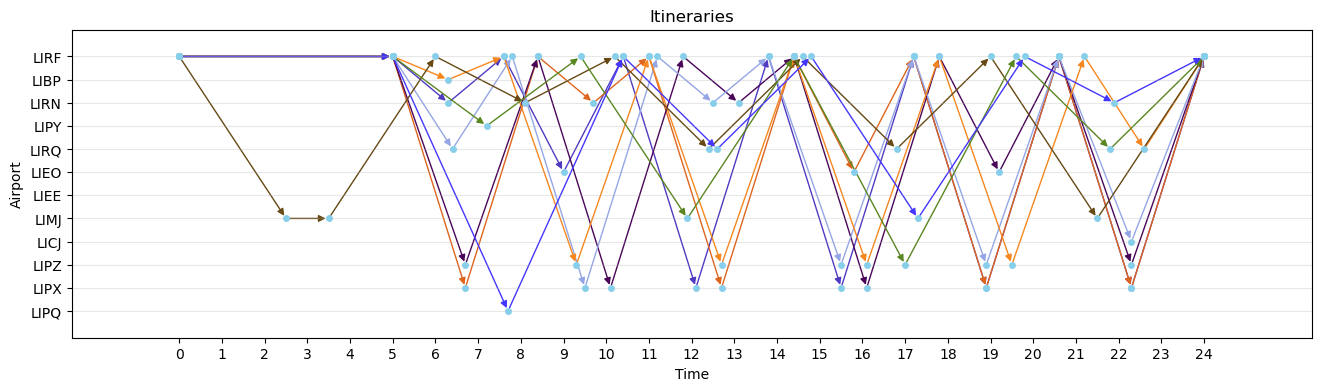

In [25]:
# Make a general graph for all itineraries

fig, ax = plt.subplots(figsize=(16, 4))

for i, g in enumerate(general_graph):
    pos = nx.get_node_attributes(g, 'pos')
    iteration_color = np.random.rand(3,)
    nx.draw_networkx(g, pos, arrows=True, with_labels=False, node_size=20, node_color='skyblue', edge_color= iteration_color, linewidths=0.5, font_size=8, label='Itinerary', ax=ax)

# Show the axes and the ticks
ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    
    # Add the axes labels for the airports and the time with ticks every hour
ax.set_xticks(np.arange(0, 25, 1))
ax.set_xticklabels(np.arange(0, 25, 1))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_yticks(np.arange(0, len(airport_list)))
ax.set_yticklabels(reversed(airport_list))
    
plt.xlabel('Time')
plt.ylabel('Airport')
plt.title('Itineraries')
plt.grid(axis = 'y', alpha = 0.3)

# Show the plot
plt.show()

In [26]:
# Filter the general output to only show flights to and from airport_info['ICAO Code'].iloc[1]
general_output_df['Load Factor'] = general_output_df.apply(lambda x: x['Passengers'] / aircraft_info[x['Aircraft type']]['Seats'], axis=1)
first_regional = general_output_df[(general_output_df['Origin'] == important_airport) | (general_output_df['Destination'] == important_airport)]
first_regional.to_csv('First_regional.csv')

In [27]:
# For each OD pair count the number of flights
total_pass_OD = general_output_df.groupby(['OD Pair'])['Passengers'].sum()
freq_airport = pd.DataFrame(general_output_df['OD Pair'].value_counts() / 2)
freq_airport.reset_index(inplace=True)
freq_airport.columns = ['OD Pair', 'Frequency']
freq_airport['Frequency one way'] = freq_airport.apply(lambda x: math.ceil(x['Frequency']), axis=1)
freq_airport = freq_airport.merge(total_pass_OD, on='OD Pair', how='left')
freq_airport

,OD Pair,Frequency,Passengers
0,LIPX - LIRF,11,990.000000
1,LIPZ - LIRF,9,816.000000
2,LIRF - LIRQ,6,564.000000
3,LIRF - LIRN,6,552.000000
4,LIMJ - LIRF,4,328.078237
5,LIEO - LIRF,3,270.000000
6,LICJ - LIRF,1,90.000000
7,LIBP - LIRF,1,79.133054
8,LIPY - LIRF,1,82.549311
9,LIPQ - LIRF,1,84.630595
